<a href="https://colab.research.google.com/github/threegenie/knn_project/blob/main/new_work_times_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
dft = pd.read_table('불용어.txt')
df_dict = dft.to_dict()
col_list = list(df_dict[dft.columns[0]].values())

### 그래프 한글 깨짐

In [19]:
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use("ggplot")
plt.rc('font', family='Malgun Gothic')

### 데이터 불러오기

In [1]:
import pandas as pd
import os, sys
import numpy as np

df = pd.read_csv('동화데이터_최종.csv')

#원래는 2016~2020 New York Times 기사를 전부 쓰고 싶었으나..... 시간적 한계로 2020년 데이터만 사용 ㅠㅠ 

In [2]:
df.head()

,제목,내용,카테고리,키워드,테마
0,고양이와 쥐의 파트너십(동반자관계),쥐를 친구로 된 어떤 고양이가 살고 있었다. \r\n고양이는 자신이 쥐에 대해 사랑...,그림형제동화,"['고양이', '돼지 비계', '이름', '항아리', '세례', '대모', '친구'...",교회
1,건달들의 무리,하루는 수탉이 암탉에게 말했다. \r\n“나무열매들이 익어 가는 계절이 왔는데 슬슬...,그림형제동화,"['수탉', '암탉', '오리', '나그네', '주막 주인', '마차']",숲속
2,실 잣는 세 여인네들,옛날 옛적에 게을러서 실을 잣지 않으려는 소녀가 한 명 있었어요.\r\n엄마가 뭐라...,그림형제동화,"['소녀', '엄마', '왕비', '게으름', '세여인']",왕국
3,"지푸라기, 숯, 콩",옛날 어느 마을에 가난한 노파가 한 명 살고 있었어요.\r\n그녀는 접시에 콩들을 ...,그림형제동화,"['숯', '지푸라기', '콩', '탈출', '재봉사', '도움']",마을
4,"생쥐, 새, 소시지",옛날 어느 날 생쥐와 새와 ‘소시지’가 동무가 되어 한 집에서 살게 되었어요.\r\...,그림형제동화,"['소시지', '생쥐', '새', '뗄감', '요리', '후회']",숲속


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      442 non-null    object
 1   내용      442 non-null    object
 2   카테고리    442 non-null    object
 3   키워드     442 non-null    object
 4   테마      442 non-null    object
dtypes: object(5)
memory usage: 17.4+ KB


#### 불용어 제거 및 형태소 분석

In [8]:
!pip install squarify

In [5]:
import re
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.tokenizer import Tokenizer

In [49]:
dft = pd.read_table('불용어.txt')
df_dict = dft.to_dict()
col_list = list(df_dict[dft.columns[0]].values())

In [50]:
from konlpy.tag import Okt
import re

# 불용어 목록(파일)
st_words = col_list

okt = Okt()

def tokenize(text):
    text = text.lower()
    text = text.replace("\n", " ")

    subst = ""
    regex = "[^가-힣0-9 ]"
    doc = re.sub(regex, subst, text)

    tokens = []
    
    # 형태소 분석 및 품사 태깅
    for word, pos in okt.pos(doc):
        if word not in st_words and pos in ['Noun', 'Verb', 'Adjective', 'Adverb']:
            tokens.append(word)
    
    return tokens

In [51]:
df['Tokens']=df['내용'].apply(tokenize)
df['Tokens'].head(3)

0    [쥐, 친구, 된, 고양이, 살, 있었다, 고양이, 쥐, 대해, 사랑, 우정, 느낀...
1    [하루, 수탉, 암탉, 말, 했다, 나무, 열매, 익어, 가는, 계절, 왔는데, 슬...
2    [옛날, 옛적, 게을러서, 실, 잣, 않으려는, 소녀, 한, 명, 있었어요, 엄마,...
Name: Tokens, dtype: object

#### 단어 빈도에 따라 시각화

In [52]:
def word_count(docs):
   
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [53]:
from collections import Counter
word_counts = Counter()
df['Tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(10)

[('말', 1480),
 ('한', 733),
 ('수', 525),
 ('사람', 470),
 ('내', 425),
 ('집', 388),
 ('있는', 334),
 ('거', 329),
 ('해', 316),
 ('그녀', 305)]

In [54]:
wc = word_count(df['Tokens'])
wc.head(5)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
237,말,368,1480,1.0,0.018626,0.018626,0.832579
105,한,287,733,2.0,0.009225,0.027851,0.649321
342,수,239,525,3.0,0.006607,0.034458,0.540724
1068,사람,180,470,4.0,0.005915,0.040374,0.407240
386,내,187,425,5.0,0.005349,0.045722,0.423077


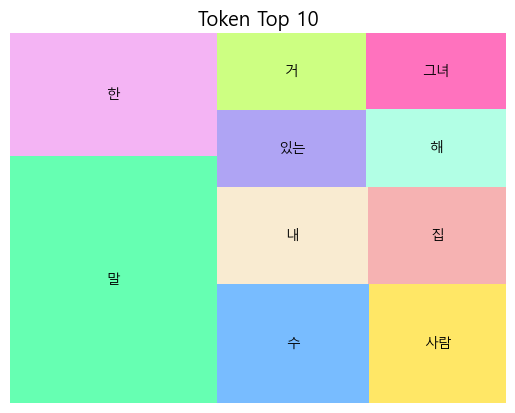

In [55]:
import squarify
import matplotlib.pyplot as plt

colors=['springgreen','violet','dodgerblue','gold','wheat','lightcoral',
        'mediumslateblue','greenyellow','aquamarine','deeppink']

wc_top5 = wc[wc['rank'] <= 10]
squarify.plot(sizes=wc_top5['percent'], label=wc_top5['word'], alpha=0.6, color=colors)
plt.axis('off')
plt.title('Token Top 10')
plt.show()

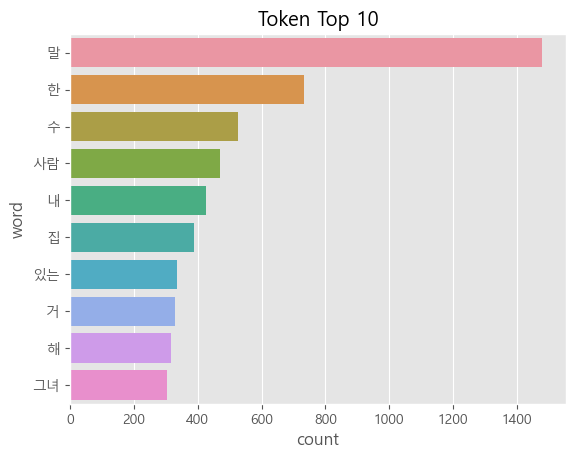

In [56]:
sns.set_palette('GnBu')
sns.barplot(x=wc['count'][:10],y=wc['word'][:10],orient='h')
plt.title('Token Top 10')
plt.show()

#### KNN + TfidVectorizer 

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=st_words
                        ,tokenizer=tokenize
                        ,ngram_range = (1,2)
                        ,max_features = 5000
                        )

dtm = tfidf.fit_transform(df['내용'])
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names_out())

In [59]:
dtm.head()

,가게,가격,가고,가기,가까운,가까이,가난,가난한,가난한 남자,가난한 사람,...,히,히죽,힘,힘 다해,힘 세고,힘 센,힘껏,힘든,힘들게,힘차게
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.015568,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.049945,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.021218,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.028577,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.038972,0.0,0.0


In [60]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree') #최근접 5이웃
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree')

In [99]:
result = nn.kneighbors([dtm.iloc[0]]) # 특정 행과 가장 유사한 문서를 찾는다.
result

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(array([[0.        , 1.19738632, 1.23215852, 1.23751342, 1.25147476]]),
 array([[  0,  21,  18, 204, 238]], dtype=int64))

In [100]:
df.iloc[result[1][0]]

,제목,내용,카테고리,키워드,테마,Tokens,label
0,고양이와 쥐의 파트너십(동반자관계),쥐를 친구로 된 어떤 고양이가 살고 있었다. \r\n고양이는 자신이 쥐에 대해 사랑...,그림형제동화,"['고양이', '돼지 비계', '이름', '항아리', '세례', '대모', '친구'...",교회,"[쥐, 친구, 된, 고양이, 살, 있었다, 고양이, 쥐, 대해, 사랑, 우정, 느낀...",0
21,여우와 고양이,우연히 고양이가 숲에서 여우를 만났어요.\r\n고양이가 속으로 생각했어요.\r\n“...,그림형제동화,"['여우', '고양이', '오만함']",숲속,"[우연히, 고양이, 숲, 여우, 만났어요, 고양이, 속, 생각, 영리하고, 경험, ...",0
18,세 행운아 (삼 형제의 행운),"아빠가 한 번은 세 아들을 자기 앞으로 불러, 첫째에게는 수탉 한 마리를, 둘째에게...",그림형제동화,"['아빠', '아들', '고양이', '왕', '궁전']",마을,"[아빠, 한, 번은, 세, 아들, 앞, 불러, 첫째, 수탉, 한, 마리, 둘째, 큰...",0
204,고양이와 생쥐들,어떤 집이 생쥐들로 넘쳐나고 있었어요.\r\n소문을 듣고 고양이 한 마리가 냉큼 그...,이솝우화,"['생쥐', '고양이', '소문', '꾀']",집,"[집, 생쥐, 넘쳐나고, 있었어요, 소문, 듣고, 고양이, 한, 마리, 냉큼, 집,...",0
238,독수리와 고양이와 암멧돼지,높은 떡갈나무 꼭대기에 독수리가 둥지를 만들었어요.\r\n그리고 그 나무줄기 중간에...,이솝우화,"['독수리', '고양이', '멧돼지', '교활함']",숲속,"[높은, 떡갈나무, 꼭대기, 독수리, 둥지, 만들었어요, 나무, 줄기, 중간, 고양...",0


In [101]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
print(df['내용'].iloc[result[1][0]])

0      쥐를 친구로 된 어떤 고양이가 살고 있었다. \r\n고양이는 자신이 쥐에 대해 사랑...
21     우연히 고양이가 숲에서 여우를 만났어요.\r\n고양이가 속으로 생각했어요.\r\n“...
18     아빠가 한 번은 세 아들을 자기 앞으로 불러, 첫째에게는 수탉 한 마리를, 둘째에게...
204    어떤 집이 생쥐들로 넘쳐나고 있었어요.\r\n소문을 듣고 고양이 한 마리가 냉큼 그...
238    높은 떡갈나무 꼭대기에 독수리가 둥지를 만들었어요.\r\n그리고 그 나무줄기 중간에...
Name: 내용, dtype: object


- 특정 동화를 입력하면 유사한 동화를 출력

#### 특정 주제에 관한 동화들을 분류하는 모델 만들기 - 은혜에 대한 동화

**타겟 라벨 만들기**

In [77]:
for row in df['내용']:
  df['내용'] = df['내용'].str.lower()

In [78]:
grace = df['내용'].str.contains('은혜')
df['label'] = grace

In [79]:
df['label'] = df['label'].astype(int)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      442 non-null    object
 1   내용      442 non-null    object
 2   카테고리    442 non-null    object
 3   키워드     442 non-null    object
 4   테마      442 non-null    object
 5   Tokens  442 non-null    object
 6   label   442 non-null    int32 
dtypes: int32(1), object(6)
memory usage: 22.6+ KB


In [81]:
df['label'].value_counts()

label
0    428
1     14
Name: count, dtype: int64

**훈련, 테스트셋 분리**

In [83]:
from sklearn.model_selection import train_test_split

train = df['내용']
target = df['label']

x_train, x_test, y_train, y_test = train_test_split(train, target, test_size = 0.3, random_state = 11)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((309,), (133,), (309,), (133,))

**Baseline**

In [84]:
#Baseline - logistic regression
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

vect = TfidfVectorizer(stop_words=st_words
                       , ngram_range=(1,2)
                       , min_df=2
                       , max_df=0.7
                        ,tokenizer=tokenize
                       , max_features=10000
                      )

svd = TruncatedSVD(algorithm='randomized'
                   , n_iter=5
                   , random_state=11)


lgs = LogisticRegression()

pipe_baseline = Pipeline([
  ('vect', vect)
  , ('svd', svd)
  , ('lgs', lgs)
])

In [85]:
pipe_baseline.fit(x_train,y_train)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가서', '각하', '간', '같다면', '같은', '개', '거나', '거리', '걸', '겁', '것과', '견지', '결과', '결론', '고려', '곤', '곳', '공동', '관', '관계', '관련', '구체', '구토', '그러한', '그런', '그럼에도', '그렇게', '그치지', '근거', '기대', '기점', '기준', '김', '까닭', '나머지', '남', '낫다', '낼', '년도', '논', '누가', '다', '다를가', '다시', '달려', '답', '대로', '대하', '대해', '더', '더욱이', '도달', '도착', '동시', '됏', '되는', '되다', '되면', '되어', '된', '된다', '될것이다', '두번째', '뒤', '든', '들면', '들자면', '듯', '따르는', '따름', '따지지', '때문', '라면', '리하', '마자', '막론', '만', '만이', '만하', '많은', '말', '망정', '메', '모른다', '몰라도', '몰랏다', '무릎', '미치다', '바', '바꾸어서', '바꿔', '반대', '방면', '보다', '보면', '보아', '본대', '부류', '불구', '불문', '비', '비걱거리',

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.7, max_features=10000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['가', '가까스로', '가령', '각', '각각', '각자',
                                             '각종', '갖고말하자면', '같다', '같이',
                                             '개의치않고', '거니와', '거바', '거의', '것',
                                             '것과 같이', '것들', '게다가', '게우다', '겨우',
                                             '견지에서', '결과에 이르다', '결국',
                                             '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로',
                                             '곧', '공동으로', '과', ...],
                                 tokenizer=<function tokenize at 0x000001EB57ED9F80>)),
                ('svd', TruncatedSVD(random_state=11)),
                ('lgs', LogisticRegression())])

In [86]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred_base = pipe_baseline.predict(x_test)
accuracy_score(y_test, y_pred_base)

0.9624060150375939

In [87]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       128
           1       0.00      0.00      0.00         5

    accuracy                           0.96       133
   macro avg       0.48      0.50      0.49       133
weighted avg       0.93      0.96      0.94       133



C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Pipeline**

In [88]:
vect = TfidfVectorizer(stop_words=st_words
                       , ngram_range=(1,2)
                       , min_df=2
                       , max_df=0.7
                        ,tokenizer=tokenize
                       , max_features=10000
                      )

svd = TruncatedSVD(algorithm='randomized'
                   , n_iter=5
                   , random_state=11)

clf = RandomForestClassifier(n_estimators=500
                             , random_state=11)

pipe = Pipeline([
  ('vect', vect)
  , ('svd', svd)
  , ('clf', clf)
])

In [89]:
pipe.fit(x_train,y_train)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가서', '각하', '간', '같다면', '같은', '개', '거나', '거리', '걸', '겁', '것과', '견지', '결과', '결론', '고려', '곤', '곳', '공동', '관', '관계', '관련', '구체', '구토', '그러한', '그런', '그럼에도', '그렇게', '그치지', '근거', '기대', '기점', '기준', '김', '까닭', '나머지', '남', '낫다', '낼', '년도', '논', '누가', '다', '다를가', '다시', '달려', '답', '대로', '대하', '대해', '더', '더욱이', '도달', '도착', '동시', '됏', '되는', '되다', '되면', '되어', '된', '된다', '될것이다', '두번째', '뒤', '든', '들면', '들자면', '듯', '따르는', '따름', '따지지', '때문', '라면', '리하', '마자', '막론', '만', '만이', '만하', '많은', '말', '망정', '메', '모른다', '몰라도', '몰랏다', '무릎', '미치다', '바', '바꾸어서', '바꿔', '반대', '방면', '보다', '보면', '보아', '본대', '부류', '불구', '불문', '비', '비걱거리',

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.7, max_features=10000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words=['가', '가까스로', '가령', '각', '각각', '각자',
                                             '각종', '갖고말하자면', '같다', '같이',
                                             '개의치않고', '거니와', '거바', '거의', '것',
                                             '것과 같이', '것들', '게다가', '게우다', '겨우',
                                             '견지에서', '결과에 이르다', '결국',
                                             '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로',
                                             '곧', '공동으로', '과', ...],
                                 tokenizer=<function tokenize at 0x000001EB57ED9F80>)),
                ('svd', TruncatedSVD(random_state=11)),
                ('clf',
                 RandomForestClassifier(n_estimators=500, random_state=11))])

**Cross Validation Parameter Search**

In [90]:
# 파라미터 셋팅
parameters = {
    'vect__max_df': (0.7, 1.0) 
    ,'vect__min_df': (2, 5, 10) 
    ,'vect__max_features': (5000, 20000) 
    ,'clf__n_estimators': (100, 500) 
    ,'clf__max_depth': (10, 20, None) 
}

random_search = RandomizedSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


PicklingError: Could not pickle the task to send it to the workers.

In [91]:
random_search.best_score_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

In [92]:
random_search.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

**Accuracy score**

In [93]:
y_pred = random_search.predict(x_test)
accuracy_score(y_test, y_pred)

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [94]:
print(classification_report(y_test, y_pred))

NameError: name 'y_pred' is not defined